In [1]:
import jax.numpy as jnp

def point_magnification(x, y):
    """Calculate point source magnification at position (x,y)"""
    w = x + 1j * y

    # For a single lens, we can use the analytic formula
    w_abs_sq = x**2 + y**2
    z1 = 0.5 * w * (1.0 + jnp.sqrt(1 + 4 / w_abs_sq))
    z2 = 0.5 * w * (1.0 - jnp.sqrt(1 + 4 / w_abs_sq))

    det1 = 1.0 - 1.0 / jnp.abs(jnp.conjugate(z1)**2)
    det2 = 1.0 - 1.0 / jnp.abs(jnp.conjugate(z2)**2)

    # The total magnification is the sum of individual image magnifications
    return 1.0 / jnp.abs(det1) + 1.0 / jnp.abs(det2)

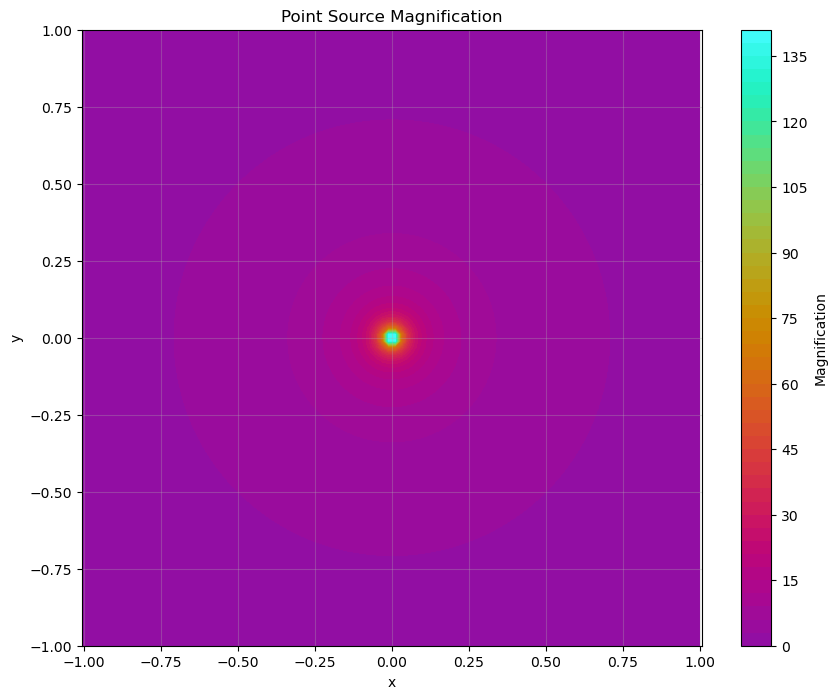

In [2]:
import matplotlib.pyplot as plt
import cmasher as cmr
import numpy as np

# Create a grid of points
n_points = 100
x = np.linspace(-1, 1, n_points)
y = np.linspace(-1, 1, n_points)
X, Y = np.meshgrid(x, y)

# Convert to JAX arrays
X_jax = jnp.array(X)
Y_jax = jnp.array(Y)

# Calculate magnification at each point
magnification = point_magnification(X_jax, Y_jax)

# Plot the magnification
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, Y, magnification, 50, cmap=cmr.tropical)
plt.colorbar(contour, label='Magnification')
plt.title('Point Source Magnification')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()


In [3]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation
from spice.plots import plot_3D, plot_3D_mesh_and_spectrum
from spice.spectrum import simulate_observed_flux
import astropy.units as u
import jax.numpy as jnp
import numpy as np
from transformer_payne import Blackbody
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import cmasher as cmr

In [4]:
bb = Blackbody()
m = IcosphereModel.construct(10000, 1., 1., bb.to_parameters(), bb.parameter_names)

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:247: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


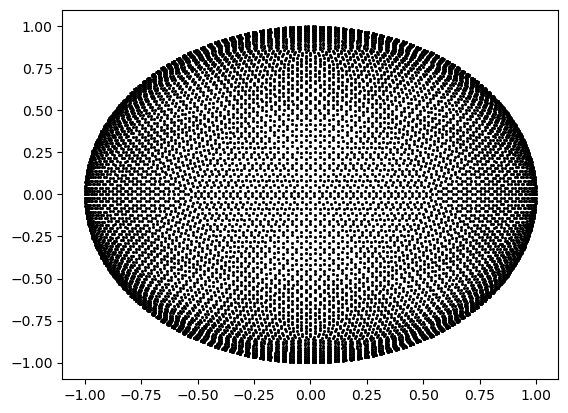

In [5]:
plt.scatter(m.cast_centers[:, 0], m.cast_centers[:, 1], color='black', s=1)

In [6]:
import astropy.constants as const
def einstein_radius(lens_mass, distance_lens, distance_source):
    d_lens_source = distance_source - distance_lens
    return jnp.sqrt(4*const.G/(const.c**2)*lens_mass*d_lens_source/distance_lens/distance_source)*2.06*1e5

Einstein radius:  0.0020153108 arcsec


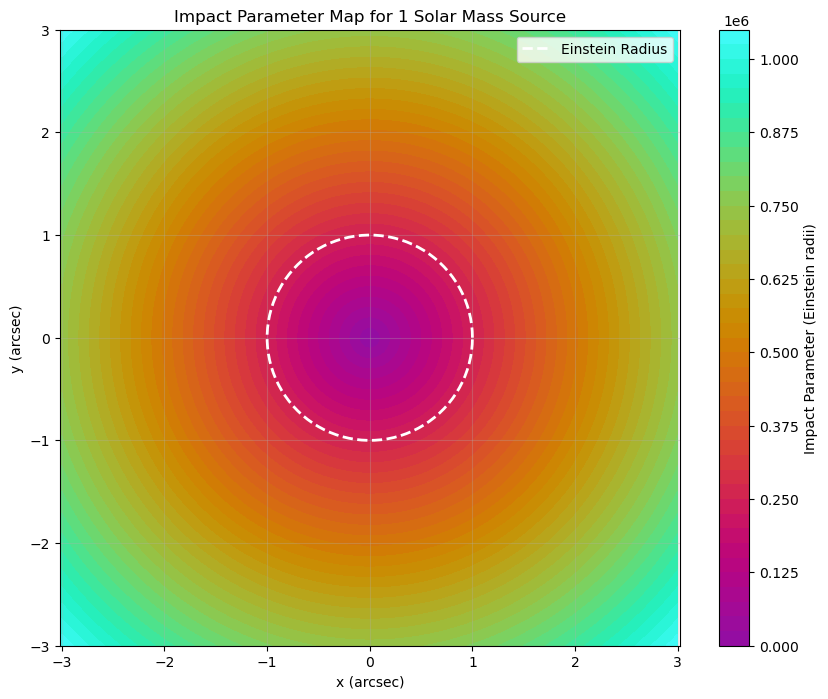

In [7]:
# Define the source mass and calculate the Einstein radius
source_mass = 1.0 * u.M_sun  # 1 solar mass
distance_lens = 1.0 * u.kpc  # Assuming a distance of 1 kiloparsec
distance_source = 2.0 * u.kpc  # Assuming a distance of 2 kiloparsecs
lens_mass = 1 * u.M_sun  # Assuming a lens mass of 1 solar mass

# Calculate the Einstein radius
einstein_radius_value = einstein_radius((lens_mass.to(u.kg)).value, (distance_lens.to(u.m)).value, (distance_source.to(u.m)).value)
print('Einstein radius: ', np.array(einstein_radius_value), 'arcsec')

# Create a grid for the impact parameter map
x = np.linspace(-3, 3, 300)
y = np.linspace(-3, 3, 300)
X, Y = np.meshgrid(x, y)

# Calculate the impact parameter (distance from the lens center)
impact_parameter = np.sqrt(X**2 + Y**2) / einstein_radius_value**2

# Plot the impact parameter map
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, Y, impact_parameter, 50, cmap=cmr.tropical)
plt.colorbar(contour, label='Impact Parameter (Einstein radii)')
plt.title('Impact Parameter Map for 1 Solar Mass Source')
plt.xlabel('x (arcsec)')
plt.ylabel('y (arcsec)')
plt.axis('equal')
plt.grid(True, alpha=0.3)

# Add the Einstein radius circle
theta = np.linspace(0, 2*np.pi, 100)
x_circle = np.cos(theta)
y_circle = np.sin(theta)
plt.plot(x_circle, y_circle, 'w--', linewidth=2, label='Einstein Radius')
plt.legend()

plt.show()


Angular sizes of different stars at various distances:
----------------------------------------------------------------------
Star Type       Diameter        Distance        Angular Size   
----------------------------------------------------------------------
Sun             2.01            solRad 1.00            pc 0.00936         arcsec
Sun             2.01            solRad 100.00          pc 0.00009         arcsec
Sun             2.01            solRad 1.00            kpc 0.00001         arcsec
Sun             2.01            solRad 10.00           kpc 0.00000         arcsec
Red Giant       201.24          solRad 1.00            pc 0.93584         arcsec
Red Giant       201.24          solRad 100.00          pc 0.00936         arcsec
Red Giant       201.24          solRad 1.00            kpc 0.00094         arcsec
Red Giant       201.24          solRad 10.00           kpc 0.00009         arcsec
Red Supergiant  2012.36         solRad 1.00            pc 9.35842         arcsec
Red Su

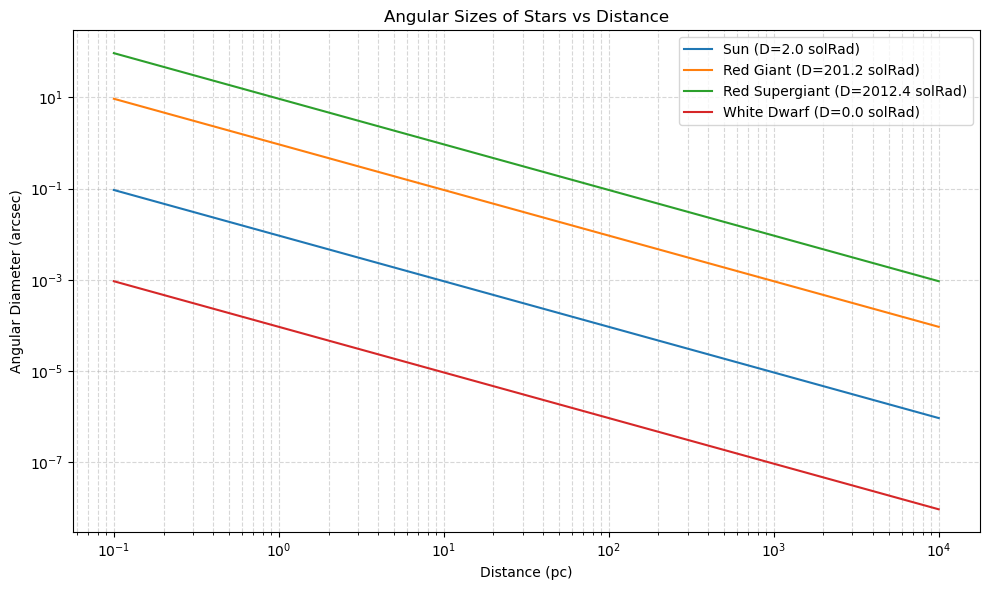


For our example microlensing event:
Angular Einstein radius: 4.156877e+02 arcsec
Angular size of source star: 4.650467e-06 arcsec
Ratio (Einstein radius / star size): 89386220.66


In [8]:
# Calculate the angular size of stars at different distances

# Function to calculate angular diameter in arcseconds
def angular_diameter(physical_diameter, distance):
    """
    Calculate the angular diameter of a star.
    
    Parameters:
    -----------
    physical_diameter : astropy.units.Quantity
        The physical diameter of the star
    distance : astropy.units.Quantity
        The distance to the star
        
    Returns:
    --------
    angular_diam : astropy.units.Quantity
        The angular diameter in arcseconds
    """
    # Angular diameter = physical diameter / distance (in radians)
    # Then convert to arcseconds
    angular_diam = (physical_diameter / distance).to(u.rad, equivalencies=u.dimensionless_angles())
    return angular_diam.to(u.arcsec)

# Example: Calculate angular diameters for different types of stars
star_types = ['Sun', 'Red Giant', 'Red Supergiant', 'White Dwarf']
diameters = [1.4e9 * u.m, 100 * 1.4e9 * u.m, 1000 * 1.4e9 * u.m, 0.01 * 1.4e9 * u.m]  # in meters
distances = [1 * u.pc, 100 * u.pc, 1 * u.kpc, 10 * u.kpc]  # Example distances

# Create a table of results
print("Angular sizes of different stars at various distances:")
print("-" * 70)
print(f"{'Star Type':<15} {'Diameter':<15} {'Distance':<15} {'Angular Size':<15}")
print("-" * 70)

for star, diam in zip(star_types, diameters):
    for dist in distances:
        ang_size = angular_diameter(diam, dist)
        print(f"{star:<15} {diam.to(u.R_sun):<15.2f} {dist:<15.2f} {ang_size:<15.5f}")

# Plot angular sizes vs distance for different star types
plt.figure(figsize=(10, 6))
distances_plot = np.logspace(-1, 4, 100) * u.pc  # 0.1 pc to 10 kpc

for star, diam in zip(star_types, diameters):
    ang_sizes = [angular_diameter(diam, d).value for d in distances_plot]
    plt.loglog(distances_plot.value, ang_sizes, label=f"{star} (D={diam.to(u.R_sun):.1f})")

plt.xlabel('Distance (pc)')
plt.ylabel('Angular Diameter (arcsec)')
plt.title('Angular Sizes of Stars vs Distance')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Compare with Einstein radius
# For a typical microlensing event, we can check if the source star is resolved
typical_source_radius = 1 * u.R_sun
typical_source_distance = distance_source
angular_source_size = angular_diameter(2 * typical_source_radius, typical_source_distance)
einstein_angle = (einstein_radius_value * u.rad).to(u.arcsec)

print(f"\nFor our example microlensing event:")
print(f"Angular Einstein radius: {einstein_angle:.6e}")
print(f"Angular size of source star: {angular_source_size:.6e}")
print(f"Ratio (Einstein radius / star size): {einstein_angle / angular_source_size:.2f}")


Text(0, 0.5, 'y (arcsec)')

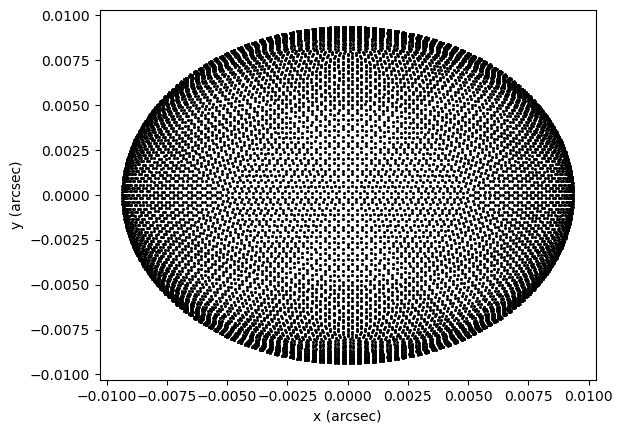

In [9]:
plt.scatter(m.cast_centers[:, 0]*0.00936, m.cast_centers[:, 1]*0.00936, color='black', s=1)
plt.xlabel('x (arcsec)')
plt.ylabel('y (arcsec)')


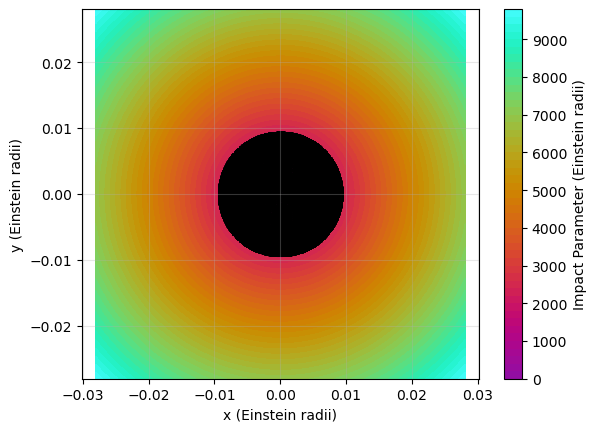

In [10]:
ang_size = 0.00936

# Create a grid for the impact parameter map
x = np.linspace(-3, 3, 300)*ang_size
y = np.linspace(-3, 3, 300)*ang_size
X, Y = np.meshgrid(x, y)

# Calculate the impact parameter (distance from the lens center)
impact_parameter = np.sqrt(X**2 + Y**2) / einstein_radius_value**2

# Plot the impact parameter map
contour = plt.contourf(X, Y, impact_parameter, 50, cmap=cmr.tropical)
plt.colorbar(contour, label='Impact Parameter (Einstein radii)')
plt.scatter(m.cast_centers[:, 0]*ang_size, m.cast_centers[:, 1]*ang_size, color='black', s=1)
plt.xlabel('x (Einstein radii)')
plt.ylabel('y (Einstein radii)')
plt.axis('equal')
plt.grid(True, alpha=0.3)

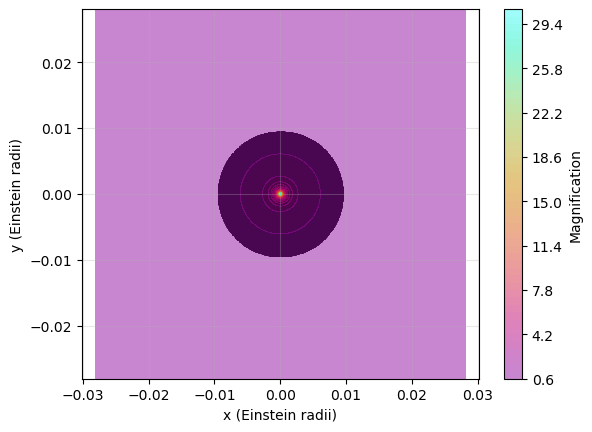

In [11]:
ang_size = 0.00936

# Create a grid for the impact parameter map
x = np.linspace(-3, 3, 300)*ang_size
y = np.linspace(-3, 3, 300)*ang_size
X, Y = np.meshgrid(x, y)

magnification = point_magnification(X/einstein_radius_value, Y/einstein_radius_value)
plt.scatter(m.cast_centers[:, 0]*ang_size, m.cast_centers[:, 1]*ang_size, color='black', s=1)
# Plot the impact parameter map
contour = plt.contourf(X, Y, magnification, 50, cmap=cmr.tropical, alpha=0.5)
plt.colorbar(contour, label='Magnification')

plt.xlabel('x (Einstein radii)')
plt.ylabel('y (Einstein radii)')
plt.axis('equal')
plt.grid(True, alpha=0.3)

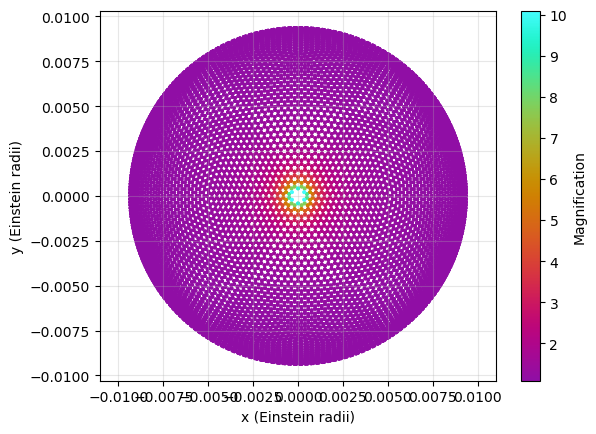

In [12]:
from spice.models.utils import cast_to_normal_plane


ang_size = 0.00936

# Create a grid for the impact parameter map
X = m.cast_centers[:, 0]*ang_size
Y = m.cast_centers[:, 1]*ang_size

# Calculate magnification for each mesh element by averaging over the triangle
# Get the vertices for each triangle
triangle_vertices = m.vertices[m.faces.astype(int)]
# Scale vertices to match the coordinate system
triangle_vertices_scaled = triangle_vertices * ang_size
# Project vertices to the plane perpendicular to line of sight
cast_triangle_vertices = jnp.array([
    cast_to_normal_plane(triangle_vertices_scaled[i], m.los_vector) 
    for i in range(len(triangle_vertices_scaled))
])
# Calculate magnification at each vertex
vertex_magnifications = jnp.array([
    point_magnification(
        cast_triangle_vertices[i, :, 0]/einstein_radius_value, 
        cast_triangle_vertices[i, :, 1]/einstein_radius_value
    ) for i in range(len(cast_triangle_vertices))
])
# Average the magnification over each triangle
magnification = jnp.mean(vertex_magnifications, axis=1)
plt.scatter(m.cast_centers[:, 0]*ang_size, m.cast_centers[:, 1]*ang_size, c=magnification, s=3, cmap=cmr.tropical)
plt.colorbar(label='Magnification')

plt.xlabel('x (Einstein radii)')
plt.ylabel('y (Einstein radii)')
plt.axis('equal')
plt.grid(True, alpha=0.3)

In [13]:
def apply_magnification(mesh, magnification):
    return mesh._replace(magnification=jnp.array(magnification))

In [28]:
from spice.models.mesh_transform import transform
import matplotlib.animation as animation
from IPython.display import HTML
import jax

@jax.jit
def create_microlensed(m, x_offset, y_offset):
    mt = transform(m, jnp.array([x_offset, y_offset, -1.1]))
    # Calculate magnification for each mesh element by averaging over the triangle
# Get the vertices for each triangle
    triangle_vertices = mt.vertices[mt.faces.astype(int)]
    # Scale vertices to match the coordinate system
    triangle_vertices_scaled = triangle_vertices * ang_size
    # Project vertices to the plane perpendicular to line of sight
    cast_triangle_vertices = jax.vmap(
        lambda vertices: cast_to_normal_plane(vertices, m.los_vector)
    )(triangle_vertices_scaled)
    # Calculate magnification at each vertex using JAX's vmap
    vertex_magnifications = jax.vmap(lambda vertices: jax.vmap(lambda vertex: 
        point_magnification(
            vertex[0]/einstein_radius_value,
            vertex[1]/einstein_radius_value
        ))(vertices))(cast_triangle_vertices)
    # Average the magnification over each triangle
    magnification = jnp.mean(vertex_magnifications, axis=1)
    return apply_magnification(mt, magnification)


In [29]:
from tqdm import tqdm

x_offsets = jnp.linspace(-2, 2, 1000)
mls = [create_microlensed(m, x_offset, -2) for x_offset in tqdm(x_offsets)]


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:02<00:00, 419.66it/s]


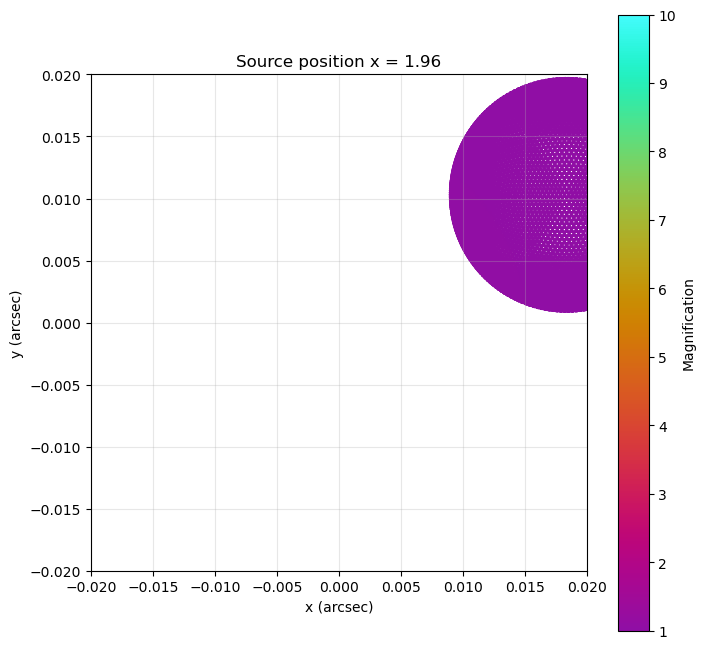

In [30]:
# Create an animation of the magnification pattern
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import Normalize
from IPython.display import HTML

# Create a figure for the animation
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Create a ScalarMappable for the colorbar with fixed normalization
norm = Normalize(vmin=1., vmax=10.0)
sm = plt.cm.ScalarMappable(cmap=cmr.tropical, norm=norm)
sm.set_array([])  # You need to set an array for the mappable

# Add the colorbar once outside the animation function
cbar = fig.colorbar(sm, ax=ax, label='Magnification')

# Function to update the plot for each frame
def update_magnification(frame):
    ax.clear()
    ml = mls[frame]
    
    # Get the magnification values
    magnification = ml.magnification
    
    # Create a scatter plot of the magnification
    scatter = ax.scatter(ml.cast_centers[:, 0]*ang_size, 
                         ml.cast_centers[:, 1]*ang_size, 
                         c=magnification, 
                         s=3, 
                         cmap=cmr.tropical,
                         norm=norm)  # Use the same norm as the colorbar
    
    # Set labels and title
    ax.set_xlabel('x (arcsec)')
    ax.set_ylabel('y (arcsec)')
    ax.set_title(f'Source position x = {x_offsets[frame]:.2f}')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    # Set consistent axis limits
    ax.set_xlim(-0.02, 0.02)
    ax.set_ylim(-0.02, 0.02)
    
    return [scatter]

# Create the animation with a subset of frames for better performance
step = 10  # Use every 10th frame
frames_to_use = range(0, len(mls), step)

# Create the animation
magnification_ani = animation.FuncAnimation(
    fig, 
    update_magnification, 
    frames=frames_to_use, 
    interval=100, 
    blit=True
)

# Display the animation in the notebook
HTML(magnification_ani.to_jshtml())


In [31]:
wvs = jnp.linspace(1, 10000, 1000)
log_wavelengths = jnp.log10(wvs)
specs = [simulate_observed_flux(bb.intensity, ml, log_wavelengths) for ml in tqdm(mls)]

100%|██████████| 1000/1000 [07:40<00:00,  2.17it/s]


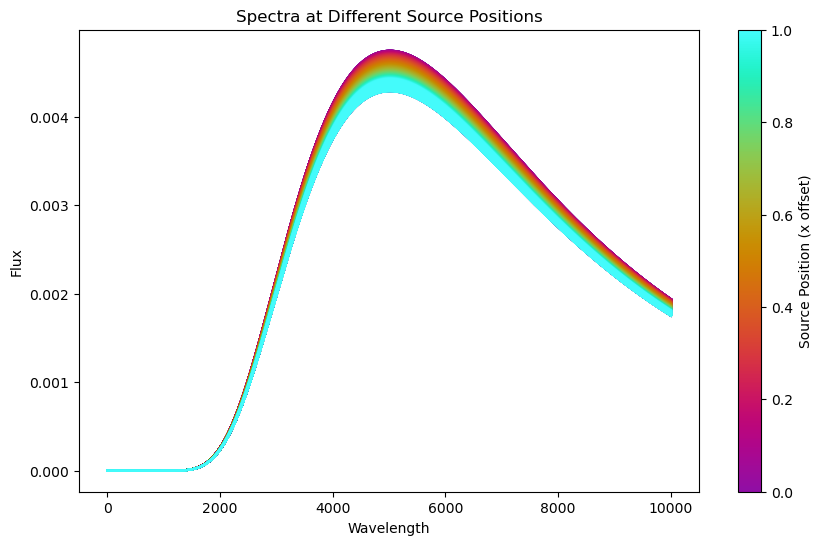

In [32]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a colormap for the phases
cmap = cmr.tropical
colors = cmap(x_offsets)

# Plot each spectrum with a color corresponding to its phase
for i, spec in enumerate(specs):
    ax.plot(wvs, spec[:, 0], color=colors[i], alpha=0.5)

# Add a colorbar to show the phase mapping
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)  # Explicitly provide the ax argument
cbar.set_label('Source Position (x offset)')

# Add labels and title
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.set_title('Spectra at Different Source Positions')

# Show the plot
plt.show()


In [33]:
from spice.spectrum import AB_passband_luminosity
from spice.spectrum.filter import Bolometric

100%|██████████| 1000/1000 [00:00<00:00, 1119.78it/s]


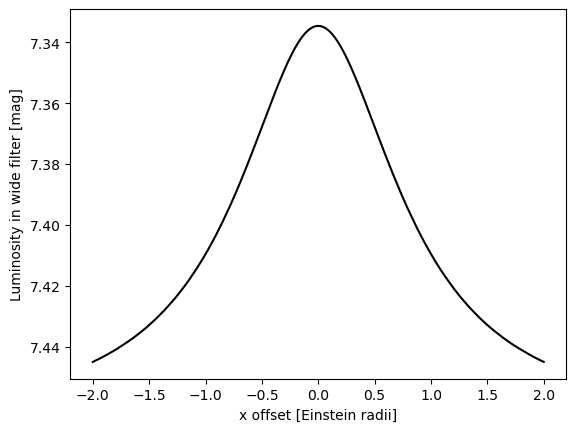

In [38]:
bol = Bolometric()

bol_lums = [AB_passband_luminosity(bol, wvs, spec[:, 0]) for spec in tqdm(specs)]

plt.plot(x_offsets, bol_lums, color='black')
plt.gca().invert_yaxis();
plt.xlabel('x offset [Einstein radii]')
plt.ylabel('Luminosity in wide filter [mag]')
plt.show()